In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [74]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [0]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

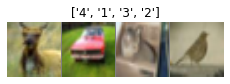

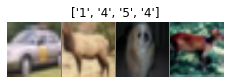

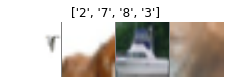

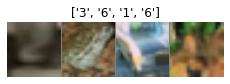

In [15]:
for i in range(4):
    show_batch_images(trainloader)

## VGG

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [0]:
vgg = models.vgg16_bn(pretrained=True)

In [0]:
for params in vgg.parameters():
  params.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [54]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

## Resnet

In [27]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.4MB/s]


In [0]:
for param in resnet.parameters():
    param.requires_grad = False

In [45]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss
opt = optim.SGD(resnet.parameters(), lr = 0.05)

## GoogleNet

In [0]:
inception = models.inception_v3(pretrained=True)

In [0]:
for param in inception.parameters():
    param.requires_grad = False

In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [0]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [80]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss
opt = optim.SGD(resnet.parameters(), lr = 0.05)

## Evaluation

In [0]:
import copy

In [0]:
def eval(model):
    loss_epoch_arr = []
    max_epochs = 1

    min_loss = 1000

    n_iters = np.ceil(50000/batch_size)

    for epoch in range(max_epochs):

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()
            if(model == "inception"):
                outputs, aux_outputs = model(inputs)
                loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
            else:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
            
            loss.backward()
            opt.step()
        
            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(inception.state_dict())
                print('Min loss %0.2f' % min_loss)
        
            if i % 100 == 0:
                print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
            del inputs, labels, outputs
            torch.cuda.empty_cache()
        
        loss_epoch_arr.append(loss.item())
        
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
            epoch, max_epochs, 
            evaluation_inception(testloader, inception), 
            evaluation_inception(trainloader, inception)))
    
    
    plt.plot(loss_epoch_arr)
    plt.show()

In [56]:
eval(vgg)

Min loss 2.29
Iteration: 0/3125, Loss: 2.29
Min loss 2.10
Min loss 1.88
Min loss 1.59
Min loss 1.53
Min loss 1.31


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=RGB size=10x8 at 0x7F6887C0FBA8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 588, in __del__
    self.fp = None
KeyboardInterrupt


Min loss 1.27
Iteration: 100/3125, Loss: 2.17
Min loss 1.11


KeyboardInterrupt: ignored

In [58]:
eval(resnet)

Min loss 2.46
Iteration: 0/3125, Loss: 2.46
Min loss 2.24
Min loss 2.21
Min loss 2.21
Iteration: 100/3125, Loss: 2.79
Min loss 2.20


KeyboardInterrupt: ignored

In [83]:
eval(inception)

RuntimeError: ignored